# CCIC GridSat time series

This notebook computes cloud amount and TIWP time series from the CCIC GridSat record.

In [1]:
from pathlib import Path

import cmocean
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

plt.style.use("../ccic.mplstyle")

In [3]:
DATA_PATH = Path("/scratch/ccic_record/data/")
cpcir_files = sorted(list((DATA_PATH / "ccic" / "cpcir" / "monthly_means").glob("*.zarr")))
print(f"Found {len(cpcir_files)} files.")

Found 296 files.


In [27]:
import ccic
mask = xr.load_dataset("/scratch/ccic_record/data/mask_24.nc").mask
with xr.open_dataset(cpcir_files[0], engine="zarr") as cpcir_data:
    lats = cpcir_data.latitude
    lons = cpcir_data.longitude
    mask = mask.astype("float32").interp(latitude=lats, longitude=lons, method="nearest").data

The code below iterates over all monthly CCIC GridSat files and calculates mean field of cloud amount (``ca``) and total ice water path (``tiwp``) as well as time series of their area-weighted means and masked means.

In [ ]:
from tqdm import tqdm
result_path = Path("/scratch/ccic_record/data/processed/ccic_cpcir_tiwp_ca.nc")

N_LATS = 3298
N_LONS = 9896

if not result_path.exists():
    times = []
    tiwp_avg = []
    tiwp_avg_masked = []
    ca_avg = []
    ca_avg_masked = []

    #  Variables to track overall mean
    tiwp_sum = np.zeros((N_LATS, N_LONS))
    tiwp_cts = np.zeros((N_LATS, N_LONS))
    ca_sum = np.zeros((N_LATS, N_LONS))
    ca_cts = np.zeros((N_LATS, N_LONS))

    # Variables to track monthly means
    tiwp_sum_m = np.zeros((12, N_LATS, N_LONS))
    tiwp_cts_m = np.zeros((12, N_LATS, N_LONS))
    ca_sum_m = np.zeros((12, N_LATS, N_LONS))
    ca_cts_m = np.zeros((12, N_LATS, N_LONS))

    # Containers to track yearly means
    tiwp_sum_yr = {}
    tiwp_cts_yr = {}
    ca_sum_yr = {}
    ca_cts_yr = {}


    for cpcir_file in tqdm(cpcir_files):
        with xr.open_dataset(cpcir_file) as cpcir_data:

            lats = cpcir_data.latitude.data
            weights = np.broadcast_to(np.cos(np.deg2rad(lats))[:, np.newaxis], (N_LATS, N_LONS))
            times.append(cpcir_data.month.data[0])

            month = cpcir_data.month.dt.month[0]
            year = cpcir_data.month.dt.year[0].item()

            tiwp = cpcir_data.tiwp.data[0]
            valid = np.isfinite(tiwp)
            tiwp_sum[valid] += tiwp[valid]
            tiwp_cts += valid.astype("float32")
            tiwp_avg.append((tiwp[valid] * weights[valid]).sum() / weights[valid].sum())
            tiwp_avg_masked.append(
                (tiwp[valid] * (mask * weights)[valid]).sum()
                / (mask * weights)[valid].sum()
            )
            tiwp_sum_m[month - 1, valid] += tiwp[valid]
            tiwp_cts_m[month - 1] += valid.astype("float32")
            
            sum_yr = tiwp_sum_yr.setdefault(year, np.zeros((N_LATS, N_LONS)))
            sum_yr[valid] += tiwp[valid]
            cts_yr = tiwp_cts_yr.setdefault(year, np.zeros((N_LATS, N_LONS)))
            cts_yr += valid.astype("float32")

            ca = cpcir_data.cloud_prob_2d.data[0] > 0.448
            valid = (-500 < ca) * (ca < 500)
            ca_sum[valid] += ca[valid]
            ca_cts += valid.astype("float32")
            ca_avg.append((ca[valid] * weights[valid]).sum() / weights[valid].sum())
            ca_avg_masked.append(
                (ca[valid] * (mask * weights)[valid]).sum()
                / (mask * weights)[valid].sum()
            )
            ca_sum_m[month - 1, valid] += ca[valid]
            ca_cts_m[month - 1] += valid.astype("float32")
            sum_yr = ca_sum_yr.setdefault(year, np.zeros((N_LATS, N_LONS)))
            sum_yr[valid] += ca[valid]
            cts_yr = ca_cts_yr.setdefault(year, np.zeros((N_LATS, N_LONS)))
            cts_yr += valid.astype("float32")
            
    times = np.array(times)
    tiwp_avg = np.array(tiwp_avg)
    ca_avg = np.array(ca_avg)
    tiwp = tiwp_sum / tiwp_cts
    ca = ca_sum / ca_cts
    
    tiwp_m = tiwp_sum_m / tiwp_cts_m
    ca_m = ca_sum_m / ca_cts_m
    
    years = np.array(list(tiwp_sum_yr.keys()))
    tiwp_yr = np.stack([tiwp_sum_yr[year] / tiwp_cts_yr[year] for year in years])
    ca_yr = np.stack([ca_sum_yr[year] / ca_cts_yr[year] for year in years])
    
    results = xr.Dataset(
        {
            "time": ("time", times),
            "latitude": (("latitude",), cpcir_data.latitude.data),
            "longitude": (("longitude",), cpcir_data.longitude.data),
            "year": (("year",), years),
            "tiwp_avg": ("time", tiwp_avg),
            "tiwp_avg_masked": ("time", tiwp_avg_masked),
            "ca_avg": ("time", ca_avg),
            "ca_avg_masked": ("time", ca_avg_masked),
            "tiwp": (("latitude", "longitude"), tiwp),
            "ca": (("latitude", "longitude"), ca),
            "tiwp_monthly": (("month", "latitude", "longitude"), tiwp_m),
            "ca_monthly": (("month", "latitude", "longitude"), ca_m),
            "tiwp_yearly": (("year", "latitude", "longitude"), tiwp_yr),
        }
    )
    results.to_netcdf(result_path)
    
else:
    results = xr.load_dataset(result_path)

  0%|                                                                                                                                                                  | 0/296 [00:00<?, ?it/s]/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch/spfrnd/micromamba/envs/ccic_record/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
  0%|▌                                                                                                                                                

In [34]:
times = np.array(times)
tiwp_avg = np.array(tiwp_avg)
ca_avg = np.array(ca_avg)
tiwp = tiwp_sum / tiwp_cts
ca = ca_sum / ca_cts

tiwp_m = tiwp_sum_m / tiwp_cts_m
ca_m = ca_sum_m / ca_cts_m

years = np.array(list(tiwp_sum_yr.keys()))
tiwp_yr = np.stack([tiwp_sum_yr[year] / tiwp_cts_yr[year] for year in years])
ca_yr = np.stack([ca_sum_yr[year] / ca_cts_yr[year] for year in years])

results = xr.Dataset(
    {
        "time": ("time", times),
        "latitude": (("latitude",), cpcir_data.latitude.data),
        "longitude": (("longitude",), cpcir_data.longitude.data),
        "year": (("year",), years),
        "tiwp_avg": ("time", tiwp_avg),
        "tiwp_avg_masked": ("time", tiwp_avg_masked),
        "ca_avg": ("time", ca_avg),
        "ca_avg_masked": ("time", ca_avg_masked),
        "tiwp": (("latitude", "longitude"), tiwp),
        "ca": (("latitude", "longitude"), ca),
        "tiwp_monthly": (("month", "latitude", "longitude"), tiwp_m),
        "ca_monthly": (("month", "latitude", "longitude"), ca_m),
        "tiwp_yearly": (("year", "latitude", "longitude"), tiwp_yr),
    }
)
results.to_netcdf(result_path)

In [ ]:
times

results = xr.Dataset(
    {
        "time": ("time", times),
        "latitude": (("latitude",), cpcir_data.latitude.data),
        "longitude": (("longitude",), cpcir_data.longitude.data),
        "year": (("year",), years),
        "tiwp_avg": ("time", tiwp_avg),
        "tiwp_avg_masked": ("time", tiwp_avg_masked),
        "ca_avg": ("time", ca_avg),
        "ca_avg_masked": ("time", ca_avg_masked),
        "tiwp": (("latitude", "longitude"), tiwp),
        "ca": (("latitude", "longitude"), ca),
        "tiwp_monthly": (("month", "latitude", "longitude"), tiwp_m),
        "ca_monthly": (("month", "latitude", "longitude"), ca_m),
        "tiwp_yearly": (("year", "latitude", "longitude"), tiwp_yr),
    }
)
results.to_netcdf(result_path)

## Global distributions

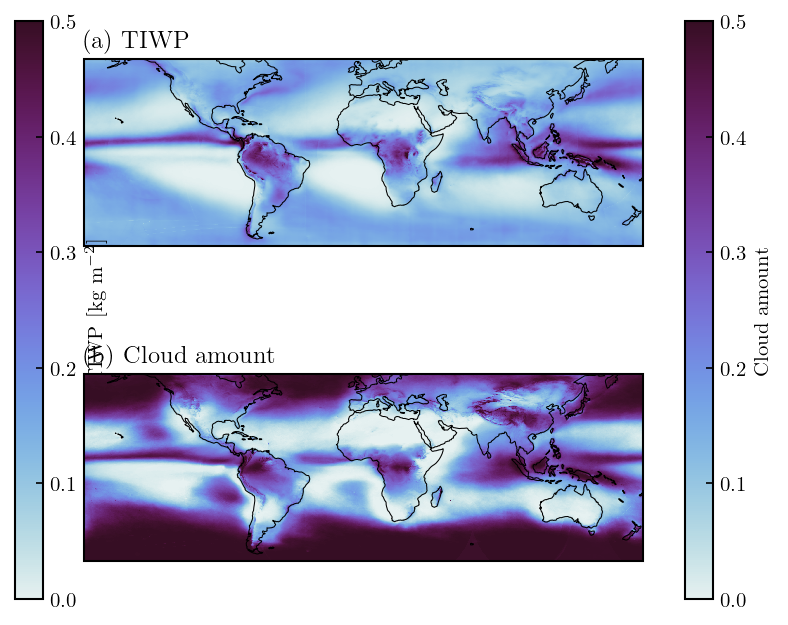

In [43]:
import cmocean
import matplotlib
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
matplotlib.style.use("../ccic.mplstyle")

fig = plt.figure(figsize=(6, 5))
gs = GridSpec(2, 3, width_ratios=[0.05, 1.0, 0.05])
crs = ccrs.PlateCarree()

lons = results.longitude.data
lats = results.latitude.data

ax = fig.add_subplot(gs[0, 1], projection=crs)
m = ax.pcolormesh(lons[::4], lats[::4], results["tiwp"].data[::4, ::4], vmin=0, vmax=0.5)
ax.set_title("(a) TIWP")
ax.coastlines()

ax = fig.add_subplot(gs[:, 0])
plt.colorbar(m, label="TIWP [kg m$^{-2}$]", cax=ax)

ax = fig.add_subplot(gs[1, 1], projection=crs)
m = ax.pcolormesh(lons[::4], lats[::4], results["ca"].data[::4, ::4], vmin=0, vmax=1.0)
ax.set_title("(b) Cloud fraction")
ax.coastlines()

ax = fig.add_subplot(gs[:, 2])
plt.colorbar(m, label="Cloud fraction", cax=ax)